In [1]:
import os
import cv2
import torch
import gdown
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Lambda

In [2]:
from utils import return_vocab_size, char_to_num, num_to_char

#### Download data

In [3]:
# Download and extract data
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')


Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=78e8b1ad-dc31-4746-8a4c-cd72266ae938
To: c:\Users\User\Desktop\Okul\YZV416E - Vision\project_coding\data.zip
100%|██████████| 423M/423M [00:04<00:00, 99.7MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

#### Data pipeline

In [75]:
class VideoDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.max_frames = 75
        self.max_alignments = 40

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        video_path = self.file_paths[idx]
        file_name = os.path.basename(video_path).split('.')[0]
        alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
        
        frames = self.load_video(video_path)
        alignments = self.load_alignments(alignment_path)
        
        return frames, alignments

    def load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        for _ in range(min(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), self.max_frames)):
            ret, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = frame[190:236, 80:220]
            frames.append(frame)
        cap.release()

        frames = np.array(frames, dtype=np.float32)
        mean = np.mean(frames)
        std = np.std(frames)
        frames = (frames - mean) / std

        if len(frames) < self.max_frames:
            frames = np.pad(frames, [(0, self.max_frames - len(frames)), (0, 0), (0, 0)], mode='constant')
        # channel
        frames = np.expand_dims(frames, axis=-1)
        return torch.from_numpy(frames)

    def load_alignments(self, path):
        with open(path, 'r') as f:
            lines = f.readlines()
        tokens = []
        for line in lines:
            line = line.split()
            if line[2] != 'sil':
                tokens.append(line[2])

        tokens = ' '.join(tokens)
        alignment_tensor = torch.tensor([char_to_num(char) for char in tokens], dtype=torch.int64)

        if len(alignment_tensor) < self.max_alignments:
            alignment_tensor = F.pad(alignment_tensor, (0, self.max_alignments - len(alignment_tensor)), value=-1)

        return alignment_tensor

def collate_fn(batch):
    frames, alignments = zip(*batch)
    
    frames = torch.stack(frames, dim=0)
    alignments = torch.stack(alignments, dim=0)

    return frames, alignments



video_files = [f'data/s1/{file}' for file in os.listdir('data/s1') if file.endswith('.mpg')]

dataset = VideoDataset(video_files)


In [76]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [77]:
frames, alignments = train_dataset[0]

In [78]:
frames.shape

torch.Size([75, 46, 140, 1])

lay white by l six now                  


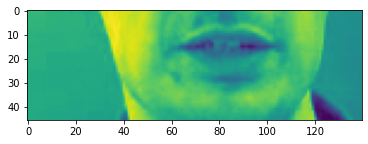

In [36]:
tensor = train_dataset[125][-1]
list_of_nums = tensor.tolist()

list_of_chars = ["".join(num_to_char(num)) for num in list_of_nums]

string_of_chars = "".join(list_of_chars)

print(string_of_chars)
plt.imshow(train_dataset[125][0][25])

#### Training

In [79]:
class VideoModel(nn.Module):
    def __init__(self, vocab_size):
        super(VideoModel, self).__init__()
        self.conv1 = nn.Conv3d(75, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv2 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv3 = nn.Conv3d(256, 75, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.lstm = nn.LSTM(75, 128, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256, vocab_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1, 75)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=2)


In [102]:
import torch
import torch.nn as nn

class Conv3DLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(Conv3DLayer, self).__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding)
        self.activation = nn.ReLU()
        self.maxpool3d = nn.MaxPool3d((1, 2, 2))

    def forward(self, x):
        x = self.conv3d(x)
        x = self.activation(x)
        x = self.maxpool3d(x)
        return x

class VideoModel(nn.Module):
    def __init__(self, vocab_size):
        super(VideoModel, self).__init__()
        self.conv1 = Conv3DLayer(1, 128, (3, 3, 3), padding=(1, 1, 1))
        self.conv2 = Conv3DLayer(128, 256, (3, 3, 3), padding=(1, 1, 1))
        self.conv3 = Conv3DLayer(256, 75, (3, 3, 3), padding=(1, 1, 1))
        self.flatten = nn.Flatten()
        self.lstm1 = nn.LSTM(75, 128, num_layers=1, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(256, 128, num_layers=1, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(256, vocab_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = x.unsqueeze(1)  # Add a dimension for TimeDistributed
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

vocab_size = return_vocab_size() + 1
model = VideoModel(vocab_size)


In [103]:
next_data = next(iter(train_loader))

In [104]:
next_data[0].shape

torch.Size([2, 75, 46, 140, 1])

In [105]:
next_data[0][0].shape

torch.Size([75, 46, 140, 1])

In [106]:
alignments.shape

torch.Size([2, 40])

In [109]:
outputs = model(next_data[0])

RuntimeError: Given groups=1, weight of size [128, 1, 3, 3, 3], expected input[1, 150, 1, 46, 140] to have 1 channels, but got 150 channels instead